In [50]:
# pip install ipympl
%matplotlib widget
from logparser import get_events_from
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import numpy as np

In [51]:
def plot_gc_hex(events, title="benchmark", fignum=0):
    def heap_limit(instruction_number):
        index = np.searchsorted(time_threshold, instruction_number, 'right')
        return np.array(threshold)[index-1]

    minor = [event for event in events if event["task"] == "gc-minor"]
    memory_used = np.array([event["total-memory-used"] for event in minor])
    
    t_minor = np.array([int(event["start"], 16)  for event in minor], dtype=float)
    start_instruction = t_minor[0]
    t_minor -= start_instruction

    time_threshold = [int(events[4]["start"],16) - start_instruction]
    threshold = [events[4]["new-threshold"]]
    begin_major_gc, end_major_gc = [], []
    for event in events:
        if event["task"] == "gc-collect-done":
            time_threshold.append(int(event["start"], 16) - start_instruction)
            threshold.append(event["new-threshold"])
    
        elif "FINALIZING" in event["text"]:
            end_major_gc.append(int(event["end"], 16) - start_instruction)
        # assumption: SCANNING only in start and final event
        elif event["task"] == "gc-collect-step" and "SCANNING" in event["text"]:
            begin_major_gc.append(int(event["start"], 16) - start_instruction)
    
    
    t_threshold = np.linspace(time_threshold[0], t_minor[-1], 300)
    y_threshold = heap_limit(t_threshold)
    plt.figure(fignum)
    plt.clf()
    plt.plot(t_minor,memory_used, 'b-', label="heap usage at minor gc")
    plt.plot(t_threshold, y_threshold, 'm', label="heap limit")
    for i in range(len(begin_major_gc)-1):
        plt.axvspan(begin_major_gc[i], end_major_gc[i], alpha=0.3, color='red')
    plt.axvspan(begin_major_gc[-1], end_major_gc[-1], alpha=0.3, color='red', label="major gc")
    plt.grid()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(EngFormatter("B"))
    ax.xaxis.set_major_formatter(EngFormatter())
    plt.xlabel("instruction number")
    plt.ylabel("memory (1 KB = 1000 B)")
    plt.title(title)
    plt.legend()
    plt.show()

In [52]:
def plot_gc(events, title = "benchmark", fignum=0):
    gc_events = [event for event in events if event["task"] == "gc-minor" or "gc-collect" in event["task"]]
    time_last_minor  = [event.get("time-last-minor-gc") for event in gc_events]
    memory_used = [event.get("total-memory-used") for event in gc_events]
    acc = 0
    time = [0]
    for time_dist in time_last_minor[1:]:
        if time_dist is not None:  
            acc += time_dist
            time.append(acc)
        else:
            time.append(None)
    time_begin_major_gc = []
    time_end_major_gc = []
    for i in range(len(gc_events)):
        if time[i] is None:
            time[i] = time[i-1] + gc_events[i-1]["time-taken"]
            if gc_events[i]["task"] == "gc-collect-step":
                if "FINALIZING" in gc_events[i]["text"]:
                    time_end_major_gc.append(time[i+1])
                elif "SCANNING" in gc_events[i]["text"]:
                    time_begin_major_gc.append(time[i])
        if memory_used[i] is None:
            memory_used[i] = memory_used[i-1]
    print(time_begin_major_gc)
    print(time_end_major_gc)
    plt.figure(fignum)
    plt.clf()
    for i in range(len(time_begin_major_gc)-1):
        plt.axvspan(time_begin_major_gc[i], time_end_major_gc[i], alpha=0.3, color='red')
    plt.axvspan(time_begin_major_gc[-1], time_end_major_gc[-1], alpha=0.3, color='red', label="major gc")
    plt.plot(time,memory_used, 'b-', label="heap usage at minor gc")
    plt.grid()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(EngFormatter("B"))
    ax.xaxis.set_major_formatter(EngFormatter("s"))
    plt.ylabel("memory (1 KB = 1000 B)")
    plt.title(title)
    plt.legend()
    plt.show()

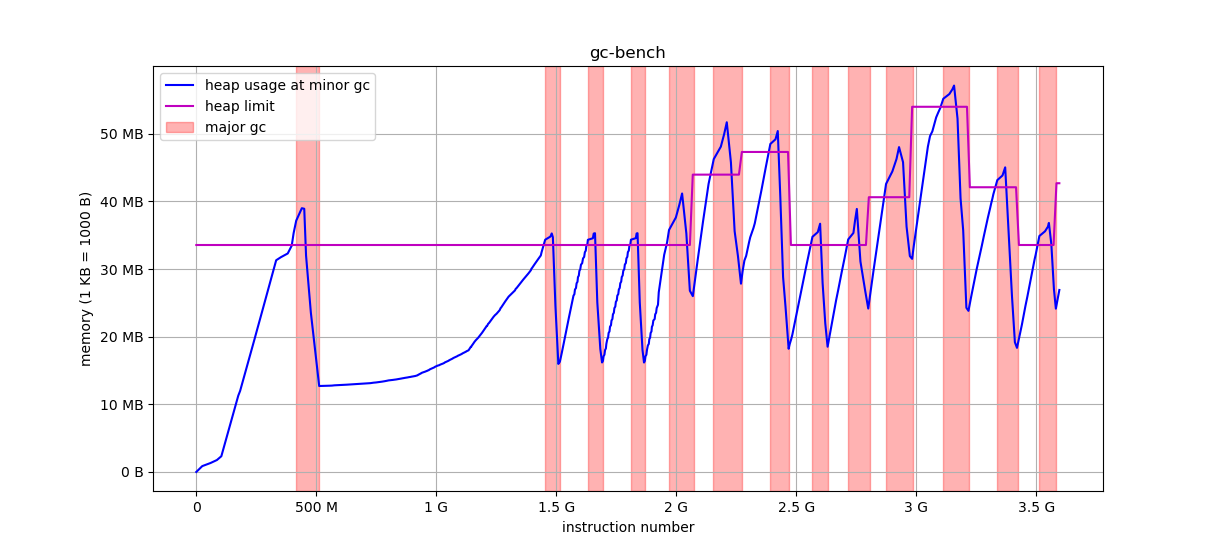

In [53]:
gcbench_events = get_events_from("logs/gcbench")
#minor = [event for event in gcbench_events if event["task"] == "gc-minor"]
#major = [event for event in events if event["task"] == "gc-collect-step"]
#both = [event for event in events if event["task"] == "gc-minor" or event["task"] == "gc-collect-step"]
#plot_gc_time(gcbench_events)
plot_gc_hex(gcbench_events, "gc-bench", 1)

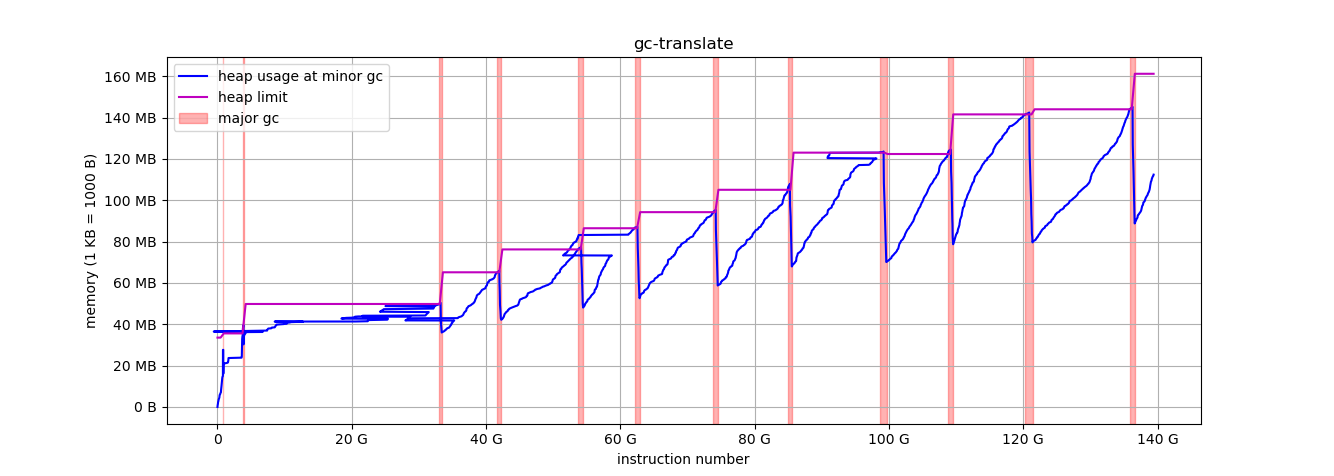

[0.30363999999999997, 1.5716959999999995, 14.205459000000003, 17.827369, 22.89528599999997, 26.381509, 31.28928499999998, 35.920890999999976, 41.64098499999997, 45.858549999999944, 50.63818499999995, 57.14408499999996]
[0.3339909999999999, 1.6287119999999997, 14.374210000000003, 18.08511, 23.22470699999997, 26.709194, 31.570527999999978, 36.180582999999984, 42.09374499999997, 46.19393299999996, 51.11018299999995, 57.47680699999996]


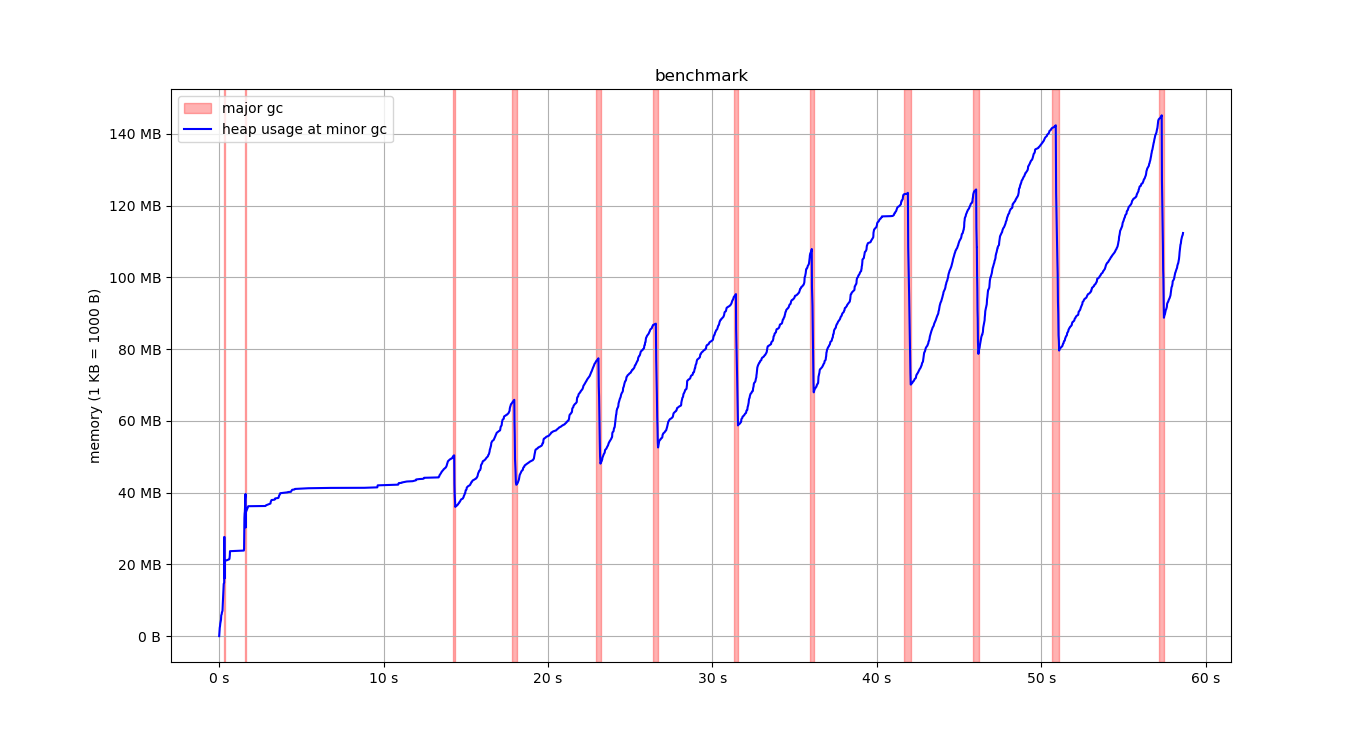

In [54]:
gctranslate_events = get_events_from("logs/gctranslate")
minor = [event for event in gctranslate_events if event["task"] == "gc-minor"]
t_minor_start = np.array([int(event["start"], 16)  for event in minor], dtype=float)
plot_gc_hex(gctranslate_events, "gc-translate", 2)
plot_gc(gctranslate_events, fignum=3)